In [392]:
import os
import scipy

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy import spatial
from typing import Tuple, Any
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from torchvision.datasets import Caltech101
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [356]:
dataset = Caltech101('./caltech101', download=True)

Files already downloaded and verified


In [259]:
def filter_by_category(category: int, max_length: int = 20):
    return [x for x in dataset if x[1] == category][:max_length]


def filter_by_categories(categories: list[int], max_length: int = 20):
    return np.concatenate([filter_by_category(c, max_length) for c in categories], dtype='object')

In [307]:
categories = [1, 2, 3, 4, 5]
small_dataset = filter_by_categories(categories)
len(small_dataset)

<__array_function__ internals>:180: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


100

In [312]:
train_dataset, test_dataset = train_test_split(small_dataset, train_size=.5)

In [313]:
def to_gray(img):
    array = np.array(img)
    gray = cv.cvtColor(array, cv.COLOR_BGR2GRAY)
    return gray

In [350]:
def sift(gray_img):
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc


def imshow_key_points(img):
    gray = to_gray(img_ex)
    kp, _ = sift(gray)
    plt.imshow(cv.drawKeypoints(gray, kp, img))
    plt.show()


def get_sift_descriptors(dataset):
    descriptors = []
    key_points = []
    for idx, (img, cls) in tqdm(enumerate(dataset)):
        array = np.array(img)
        if len(array.shape) == 3:
            gray = to_gray(img)
        else:
            gray = array
        kp, desc = sift(gray)
        key_points.append(kp)
        descriptors.append(desc)
    return np.concatenate(key_points), np.concatenate(descriptors)

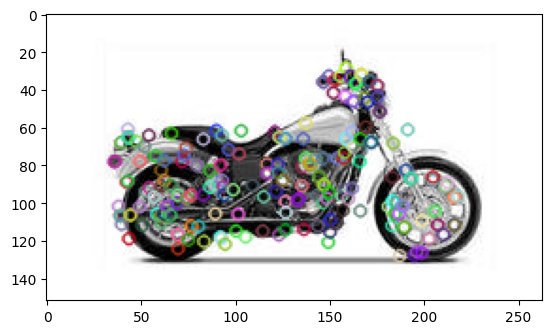

In [351]:
img_ex = train_dataset[0][0]
imshow_key_points(np.array(img_ex))

In [352]:
_, train_descriptors = get_sift_descriptors(train_dataset)
_, test_descriptors = get_sift_descriptors(test_dataset)

50it [00:00, 72.21it/s]
50it [00:00, 67.47it/s]


In [379]:
def get_the_centroids(vector, A):
    tree = spatial.KDTree(A)
    dist, idx = tree.query(vector)
    return idx


def get_bag_of_words(words, doc):
    """
      Parameters
      ----------
      words : np.array
        array of words in the vocabulary (basically centroids of the k-means)
      doc : np.array
        array of descriptors of a picture
    """
    idcs = get_the_centroids(doc, words)
    return Counter(idcs)


def elbow(ks, inertias):
    plt.plot(ks, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Values of k')
    plt.ylabel('Inertia')
    plt.show()

In [396]:
inertias = {}
clusters = {}
distortions = {}
ks = range(100, 500, 100)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_RANDOM_CENTERS
cluster_centers = {}
pred_labels = {}

for k in ks:
    print(k, end='\r')
    # kmeans = KMeans(n_clusters=k)
    # kmeans.fit(train_descriptors)
    # inertias[k] = kmeans.inertia_
    # clusters[k] = kmeans.cluster_centers_
    # kmeans.predict(test_descriptors)
    compactness, labels, centers = cv.kmeans(train_descriptors, k, None, criteria, 10, flags)
    pred_labels[k] = labels
    cluster_centers[k] = centers
    distortions[k] = sum(np.min(spatial.distance.cdist(train_descriptors, centers, 'euclidean'), axis=1)) / len(train_descriptors)

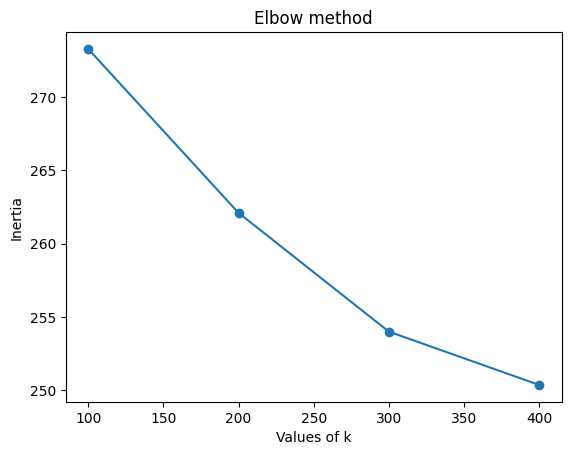

In [402]:
elbow(ks, list(distortions.values()))

In [441]:
tree = spatial.KDTree(cluster_centers[100])
dist, idx = tree.query(train_descriptors)

In [442]:
idx

array([64, 96, 10, ..., 65, 65, 65], dtype=int64)

In [443]:
Counter(idx)

Counter({64: 136,
         96: 183,
         10: 196,
         1: 223,
         68: 201,
         19: 248,
         97: 141,
         36: 405,
         47: 122,
         65: 603,
         56: 173,
         85: 129,
         42: 249,
         86: 152,
         70: 74,
         95: 170,
         4: 107,
         63: 253,
         28: 51,
         72: 223,
         61: 246,
         29: 146,
         43: 506,
         33: 224,
         35: 224,
         78: 116,
         49: 390,
         84: 257,
         55: 145,
         59: 248,
         77: 159,
         69: 142,
         83: 166,
         11: 62,
         38: 184,
         52: 278,
         44: 133,
         13: 161,
         81: 348,
         76: 149,
         48: 222,
         94: 132,
         39: 141,
         25: 152,
         74: 161,
         91: 167,
         9: 187,
         92: 172,
         21: 172,
         99: 134,
         87: 179,
         98: 689,
         7: 132,
         90: 255,
         66: 169,
         75: 148,